Training, validation and test split. First attempt at cross validation, fail, however there is improvement in single training process.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from itertools import chain
from keras.preprocessing.sequence import TimeseriesGenerator
from matplotlib import pyplot as plt
from tensorflow.keras import layers
df = pd.read_csv("drive/MyDrive/Engineer's Project/test.csv")

In [ ]:
df.pop('Date')
df.pop('usa_cpi')
df.pop('pol_cpi')
df.pop('usa_inter')
df.pop('pol_inter')
float_data1 = np.array(df).astype('float32')
mean = float_data1[:2001].mean(axis=0)
float_data1 -= mean
std = float_data1[:2001].std(axis=0)
float_data1 /= std

In [ ]:
float_data2 = np.array(df).astype('float32')
mean2 = float_data2[500:2501].mean(axis=0)
float_data2 -= mean2
std2 = float_data2[500:2501].std(axis=0)
float_data2 /= std2

In [ ]:
float_data3 = np.array(df).astype('float32')
mean3 = float_data3[1000:].mean(axis=0)
float_data3 -= mean3
std3 = float_data3[1000:].std(axis=0)
float_data3 /= std3

In [ ]:
lookback = 30
step = 1
delay = 1
min_index  = 0
batch_size = 128

In [ ]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=1):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(
        min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][3] ##### 3 is the column number that is going to be predicted
    yield samples, targets

In [ ]:
train_gen1 = generator(float_data1,
lookback=lookback,
delay=delay,
min_index=0,
max_index=2000,
shuffle=True,
step=step,
batch_size=batch_size)

In [ ]:
val_gen1 = generator(float_data1,
lookback=lookback,
delay=delay,
min_index=2001,
max_index=2500,
step=step,
batch_size=batch_size)

In [ ]:
test_gen1 = generator(float_data1,
lookback=lookback,
delay=delay,
min_index=2501,
max_index=3000,
step=step,
batch_size=batch_size)

In [ ]:
val_steps1 = (2500 - 2001 - lookback)
test_steps1 = (3000 - 2501 - lookback)

In [ ]:
train_gen2 = generator(float_data2,
lookback=lookback,
delay=delay,
min_index=500,
max_index=2500,
shuffle=True,
step=step,
batch_size=batch_size)

In [ ]:
val_gen2 = generator(float_data2,
lookback=lookback,
delay=delay,
min_index=2501,
max_index=3000,
step=step,
batch_size=batch_size)

In [ ]:
test_gen2 = generator(float_data2,
lookback=lookback,
delay=delay,
min_index=3001,
max_index=3541,
step=step,
batch_size=batch_size)

In [ ]:
val_steps2 = (3000 - 2501 - lookback)
test_steps2 = (3541 - 3001 - lookback)

In [ ]:
train_gen3 = generator(float_data3,
lookback=lookback,
delay=delay,
min_index=1000,
max_index=3541,
shuffle=True,
step=step,
batch_size=batch_size)

In [ ]:
val_gen3 = generator(float_data3,
lookback=lookback,
delay=delay,
min_index=0,
max_index=500,
step=step,
batch_size=batch_size)

In [ ]:
test_gen3 = generator(float_data3,
lookback=lookback,
delay=delay,
min_index=501,
max_index=999,
step=step,
batch_size=batch_size)

In [ ]:
val_steps3 = (500 - 0 - lookback)
test_steps3 = (999 - 501 - lookback)

In [ ]:
print(float_data1.shape[-1])
print(float_data2.shape[-1])
print(float_data2.shape[-1])

7
7
7


In [ ]:
model = tf.keras.models.Sequential()
model.add(layers.LSTM(128,
  activation='sigmoid',
  dropout=0.1,
  recurrent_dropout=0.1,
  input_shape=(None, 7)))
model.add(layers.Dense(5,
  activation='sigmoid',))
model.add(layers.Dense(1))
model.compile(optimizer= tf.keras.optimizers.Adam(), loss='mae')
history1 = model.fit(train_gen1,
  steps_per_epoch=200,
  epochs=20,
  validation_data=val_gen1,
  validation_steps=val_steps1)

Epoch 1/20
200/200 [==============================] - 37s 168ms/step - loss: 0.3043 - val_loss: 0.1341
Epoch 2/20
200/200 [==============================] - 33s 165ms/step - loss: 0.1327 - val_loss: 0.0902
Epoch 3/20
200/200 [==============================] - 33s 166ms/step - loss: 0.1020 - val_loss: 0.0557
Epoch 4/20
200/200 [==============================] - 33s 165ms/step - loss: 0.0903 - val_loss: 0.0552
Epoch 5/20
200/200 [==============================] - 44s 220ms/step - loss: 0.0846 - val_loss: 0.0546
Epoch 6/20
200/200 [==============================] - 37s 186ms/step - loss: 0.0808 - val_loss: 0.0650
Epoch 7/20
200/200 [==============================] - 33s 165ms/step - loss: 0.0775 - val_loss: 0.0537
Epoch 8/20
200/200 [==============================] - 33s 167ms/step - loss: 0.0747 - val_loss: 0.0559
Epoch 9/20
200/200 [==============================] - 35s 173ms/step - loss: 0.0736 - val_loss: 0.0659
Epoch 10/20
200/200 [==============================] - 38s 189ms/step - l

In [ ]:
eval1 = model.evaluate(test_gen1, steps = test_steps1)
eval1 *std[0]

469/469 [==============================] - 11s 23ms/step - loss: 0.0730


0.02916087217799701

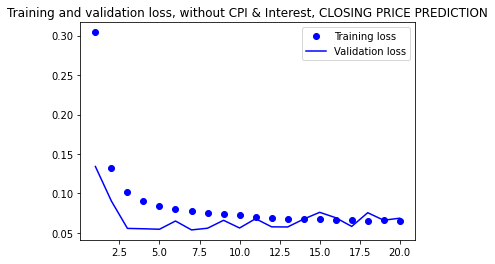

In [ ]:
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
epochs1 = range(1, len(loss1) + 1)
plt.figure()
plt.plot(epochs1, loss1, 'bo', label='Training loss')
plt.plot(epochs1, val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss, without CPI & Interest, CLOSING PRICE PREDICTION')
plt.legend()
plt.show()

In [ ]:
history2 = model.fit(train_gen2,
  steps_per_epoch=200,
  epochs=20,
  validation_data=val_gen2,
  validation_steps=val_steps2)

Epoch 1/20
200/200 [==============================] - 33s 166ms/step - loss: 0.0695 - val_loss: 0.0569
Epoch 2/20
200/200 [==============================] - 33s 165ms/step - loss: 0.0684 - val_loss: 0.0638
Epoch 3/20
200/200 [==============================] - 33s 166ms/step - loss: 0.0665 - val_loss: 0.0577
Epoch 4/20
200/200 [==============================] - 33s 165ms/step - loss: 0.0661 - val_loss: 0.0588
Epoch 5/20
200/200 [==============================] - 33s 166ms/step - loss: 0.0664 - val_loss: 0.0569
Epoch 6/20
200/200 [==============================] - 33s 166ms/step - loss: 0.0659 - val_loss: 0.0580
Epoch 7/20
200/200 [==============================] - 33s 166ms/step - loss: 0.0658 - val_loss: 0.0588
Epoch 8/20
200/200 [==============================] - 33s 165ms/step - loss: 0.0649 - val_loss: 0.0557
Epoch 9/20
200/200 [==============================] - 33s 166ms/step - loss: 0.0652 - val_loss: 0.0573
Epoch 10/20
200/200 [==============================] - 33s 167ms/step - l

In [ ]:
eval2 = model.evaluate(test_gen2, steps = test_steps2)
eval2 *std[0]

510/510 [==============================] - 11s 22ms/step - loss: 0.0626


0.025003134746166555

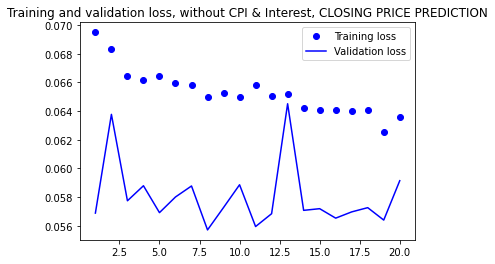

In [ ]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs2 = range(1, len(loss2) + 1)
plt.figure()
plt.plot(epochs2, loss2, 'bo', label='Training loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss, without CPI & Interest, CLOSING PRICE PREDICTION')
plt.legend()
plt.show()

3rd val loss = 0.5, reason?